# VASP TiO2 benchmark performance

This notebook compares the performance of the TiO2 benchmark (pure DFT) between ARCHER and ARCHER2 and for VASP compiled with different numerical libraries on ARCHER2.

We compute performance using the maximum time per SCF cycle from all cycles in the output file. The maximum is used as SCF cycles are non-homogeneous in this VASP benchmark with extra work being done in the later SCF cycles. In the full calculation from which this benchmark is extracted, the long SCF cycles make up the majority of the cycles and dominate the runtime.

Performance is plotted as SCF cycles per second (i.e. inverse of maximum SCF cycle time in seconds).

All calculations were performed with VASP 5.4.4.pl2:

- On ARCHER: Intel Compilers 17, FFTW, Intel MKL 17
- On ARCHER2: GCC 10.1.0, FFTW 3.3.8.8, HPE Cray MPICH 8.0.16 and various numerical libraries

## Setup section

Import the required modules and define useful functions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (12,6)
import seaborn as sns
sns.set(font_scale=1.5, context="paper", style="white", font="serif")
pal = sns.color_palette()
cols = pal.as_hex()

In [2]:
import sys
sys.path.append('../../../python-modules')

In [3]:
from utilities import filemanip, sysinfo
from appanalysis import vasp

In [4]:
sysdetails = sysinfo.getdetails('../../../systems.yaml')

../../../python-modules/utilities/sysinfo.py:6: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  systems = yaml.load(input)


## Process data

In [5]:
results = ['ARCHER','ARCHER2_LibSci-20.10','ARCHER2_MKL-19.5','ARCHER2_MKL-21.2','ARCHER2_AOCL-3.0']
systems = {
    'ARCHER': 'ARCHER',
    'ARCHER2_LibSci-20.10': 'ARCHER2',
    'ARCHER2_MKL-19.5': 'ARCHER2',
    'ARCHER2_MKL-21.2': 'ARCHER2',
    'ARCHER2_AOCL-3.0': 'ARCHER2'
}
perf = {}
notes = {}
names = {}
nodes = {}
cores = {}
perf_nodes = {}
perf_cores = {}
cpn = {}

for res in results:
    wdir = '../TiO2/results/' + res
    filelist = filemanip.get_filelist(wdir, 'TiO2MCC_')
    sysdict = sysdetails[systems[res]]
    names[res] = res
    cpn[res] = sysdict['PCores']*sysdict['PPerNode']
    print('\n============================================================')
    print(res)
    vasp_df = pd.DataFrame(vasp.create_df_list(filelist, sysdict['PCores']*sysdict['PPerNode'], perftype="max"))
    nodes[res], perf_nodes[res] = vasp.get_perf_stats(vasp_df, 'max', writestats=True, plot_cores=False)
    cores[res], perf_cores[res] = vasp.get_perf_stats(vasp_df, 'max', writestats=False, plot_cores=True)
    print('\n============================================================')


ARCHER
                                       Perf                                \
                                        min    median       max      mean   
Nodes Processes Threads NPAR KPAR                                           
2     48        1       4    1     0.000738  0.000738  0.000738  0.000738   
                        8    1     0.000716  0.000716  0.000716  0.000716   
4     96        1       4    1     0.001441  0.001441  0.001441  0.001441   
                        8    1     0.001454  0.001454  0.001454  0.001454   
8     192       1       4    1     0.002767  0.002767  0.002767  0.002767   
16    384       1       4    1     0.004865  0.004865  0.004865  0.004865   
32    768       1       4    1     0.011049  0.011049  0.011049  0.011049   

                                         SCF                                   \
                                         min     median        max       mean   
Nodes Processes Threads NPAR KPAR                          

                                       Perf                                \
                                        min    median       max      mean   
Nodes Processes Threads NPAR KPAR                                           
1     128       1       4    1     0.001413  0.001413  0.001413  0.001413   
2     256       1       2    1     0.003697  0.003697  0.003697  0.003697   
4     512       1       4    1     0.007136  0.007136  0.007136  0.007136   
                        128  1     0.004720  0.004720  0.004720  0.004720   
8     1024      1       8    1     0.013768  0.013768  0.013768  0.013768   
                        128  1     0.009908  0.009908  0.009908  0.009908   
16    2048      1       16   1     0.009741  0.009741  0.009741  0.009741   
                        128  1     0.010021  0.010021  0.010021  0.010021   
32    4096      1       32   1     0.005256  0.005256  0.005256  0.005256   
                        64   1     0.005303  0.005303  0.005303  0.005303   

## Performance Comparison

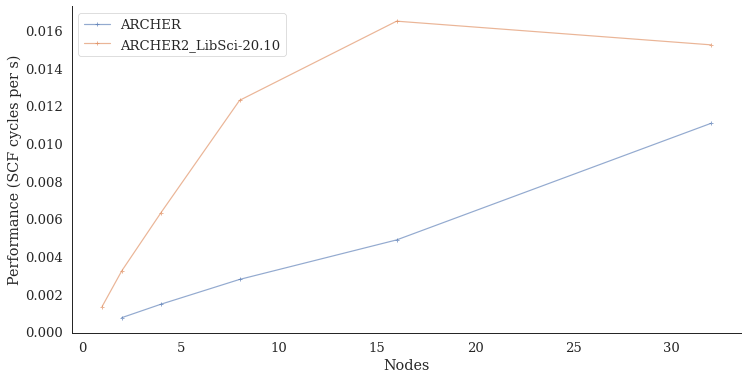

In [6]:
results = ['ARCHER','ARCHER2_LibSci-20.10']
for res in results:
    plt.plot(nodes[res], perf_nodes[res], '-+', label=names[res], alpha=0.6)
plt.xlabel('Nodes')
plt.ylabel('Performance (SCF cycles per s)')
plt.legend(loc='best')
sns.despine()

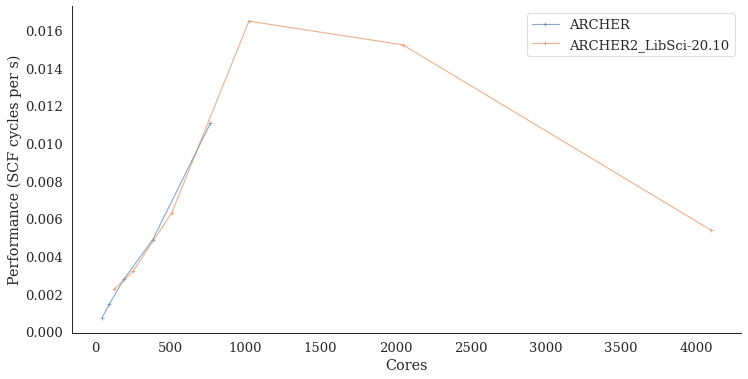

In [7]:
for res in results:
    plt.plot(cores[res], perf_cores[res], '-+', label=names[res], alpha=0.6)
plt.xlabel('Cores')
plt.ylabel('Performance (SCF cycles per s)')
plt.legend(loc='best')
sns.despine()

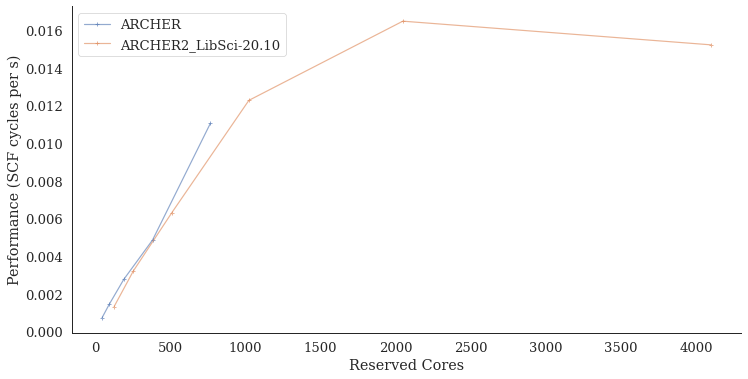

In [8]:
for res in results:
    totcores = [n * cpn[res] for n in nodes[res]]
    plt.plot(totcores, perf_nodes[res], '-+', label=names[res], alpha=0.6)
plt.xlabel('Reserved Cores')
plt.ylabel('Performance (SCF cycles per s)')
plt.legend(loc='best')
sns.despine()

## ARCHER2 numerical library performance comparison

A comparison of the performance of the same version of VASP using different numerical libraries

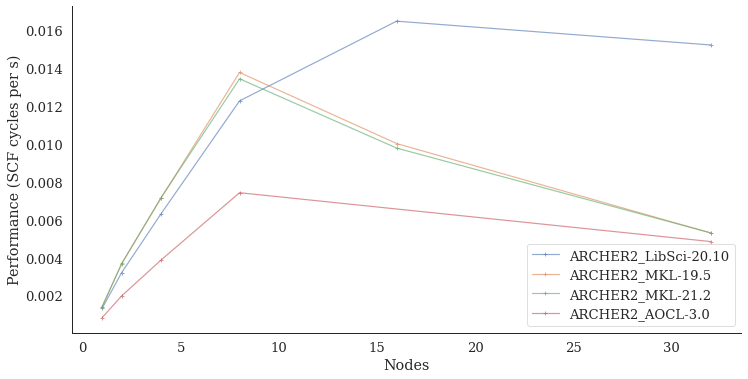

In [12]:
results = ['ARCHER2_LibSci-20.10','ARCHER2_MKL-19.5','ARCHER2_MKL-21.2','ARCHER2_AOCL-3.0']
for res in results:
    plt.plot(nodes[res], perf_nodes[res], '-+', label=names[res], alpha=0.6)
plt.xlabel('Nodes')
plt.ylabel('Performance (SCF cycles per s)')
plt.legend(loc='best')
sns.despine()
plt.savefig('vasp_tio2_numlib_perf.png', dpi=300)

In [11]:
base_perf = perf_nodes['ARCHER2_LibSci-20.10'][0]
print("1 node:")
print(f"{'Version':>20s} {'Perf.':>10s} {'Ratio':>10s}")
for res in results:
    perf = perf_nodes[res][0]
    print(f"{res:>20s} {perf:>10.5f} {perf/base_perf:>10.5f}")

print("8 nodes:")
print(f"{'Version':>20s} {'Perf.':>10s} {'Ratio':>10s}")
base_perf = perf_nodes['ARCHER2_LibSci-20.10'][3]
for res in results:
    perf = perf_nodes[res][3]
    print(f"{res:>20s} {perf:>10.5f} {perf/base_perf:>10.5f}")

1 node:
             Version      Perf.      Ratio
ARCHER2_LibSci-20.10    0.00133    1.00000
    ARCHER2_MKL-19.5    0.00141    1.06394
    ARCHER2_MKL-21.2    0.00141    1.06306
    ARCHER2_AOCL-3.0    0.00084    0.63098
8 nodes:
             Version      Perf.      Ratio
ARCHER2_LibSci-20.10    0.01227    1.00000
    ARCHER2_MKL-19.5    0.01377    1.12211
    ARCHER2_MKL-21.2    0.01343    1.09486
    ARCHER2_AOCL-3.0    0.00743    0.60534
